In [8]:
from pprint import pprint
import numpy as np
import random
import motif_ops
import seq_ops
import seq_tools
import seqlogo
from scipy.special import softmax


In [9]:
def GibbsMotifFinder(seqs, k, max_iterations=5000, threshold = 5e-10):

    #initialize ic_list to track information content over iterations
    ic_list = []

    #randomly choose motif start sites
    motif_starts = seq_tools.build_motif_starts(seqs, k)

    #Intialize pfm, just the first time.
    pfm = motif_ops.build_pfm(seq_tools.get_kmer_list(seqs, motif_starts, k), k)

    # LOOP
    i = 0 # count number of iterations
    converged = False
    while (converged != True) and (i <= max_iterations):
        
        #save a copy for next time to compare for convergence
        pfm_old = pfm.copy()
        
        # select kmer to score
        pick = random.randrange(len(motif_starts))
        
        # remove chosen kmer to score from pfm
        seq_tools.change_pfm(seqs[pick][motif_starts[pick]:motif_starts[pick]+k], k, "sub", pfm)
        
        
        #remove chosen kmer from list
        removed_seq = seqs.pop(pick)
        removed_index = motif_starts.pop(pick)
        
        #build pwm
        pwm = motif_ops.build_pwm(pfm)
        
        #get reverse complement
        rev_seq = seq_ops.reverse_complement(removed_seq)
        
        
        #score kmers
        kmer_scores = []
        #score forward seq
        for x in range(len(removed_seq) - k):
            score = motif_ops.score_kmer(removed_seq[x:x+k], pwm)
            kmer_scores.append(score)
        
        #score reverse seq
        for x in range(len(removed_seq) - k):
            score = motif_ops.score_kmer(rev_seq[x:x+k], pwm)
            kmer_scores.append(score)
        
        
        # choose "best" motif score using softmax calculation
        prob = softmax(kmer_scores)
        new_idx = np.random.choice(np.arange(len(kmer_scores)), p=prob)
        
        # use modulo to determine if chosen motif is on forward or reverse sequence
        quotient, remainder = divmod(new_idx, len(removed_seq) - k - 1)
        if quotient == 0: # forward sequence
            new_motif = removed_seq[remainder:remainder+k]
            seq_to_add_back = removed_seq
        else: # reverse sequence
            new_motif = rev_seq[remainder:remainder+k]
            seq_to_add_back = rev_seq
        
        
        # Insert the sequence and new index
        seqs.append(seq_to_add_back)
        motif_starts.append(remainder)
        
        # add new better motif to pfm
        
        seq_tools.change_pfm(new_motif, k, "add", pfm)
        
        # calculate information content and check for convergence
        new_ic = motif_ops.pfm_ic(pfm)
        old_ic = motif_ops.pfm_ic(pfm_old)
        ic_diff = abs(new_ic-old_ic)
        ic_list.append(new_ic)
        
        if ic_diff < threshold:
            print(f"\rIteration {i}, we converged with IC of {ic_diff}", end="", flush=True)        
            #converged = True
        else: 
            print(f"\rIteration {i}, did not converge yet with IC of {ic_diff}", end="", flush=True)
        i += 1
    norm_pfm = pfm / pfm.sum(axis = 1, keepdims = True)
    return norm_pfm, ic_list
    


In [10]:
'''
the bed file is prepared separately using the following commands:

# This file is generated by MACS version 3.0.3
# Command line: callpeak -t ./data/SRR9090854.subsampled_5pct.bam -n output -f BAMPE --outdir ./macs3_output/ -g hs
# ARGUMENTS LIST:
# name = output
# format = BAMPE
# ChIP-seq file = ['./data/SRR9090854.subsampled_5pct.bam']
# control file = None
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is on

# fragment size is determined as 9675 bps
'''

#load sequences from prepared bed file
seqs = seq_tools.read_file("./data/only_peaks.bed")

#call the function
norm_pfm, ic_list = GibbsMotifFinder(seqs, 8)

pprint(norm_pfm.T)

Iteration 3, did not converge yet with IC of 0.00058657071412238085

Iteration 5000, did not converge yet with IC of 0.00093815684373588238array([[0.18285714, 0.01851852, 0.03335861, 0.01162791],
       [0.14171429, 0.08333333, 0.10386657, 0.05813953],
       [0.11009524, 0.03703704, 0.15845337, 0.15116279],
       [0.072     , 0.12037037, 0.24488249, 0.01744186],
       [0.13257143, 0.03703704, 0.13191812, 0.01162791],
       [0.16952381, 0.0462963 , 0.05307051, 0.04651163],
       [0.13028571, 0.12962963, 0.10235027, 0.21511628],
       [0.06095238, 0.52777778, 0.17210008, 0.48837209]])


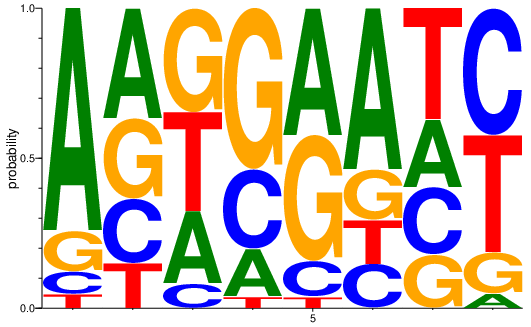

In [11]:
seqlogo.seqlogo(seqlogo.CompletePm(pfm = norm_pfm.T), ic_scale=False)

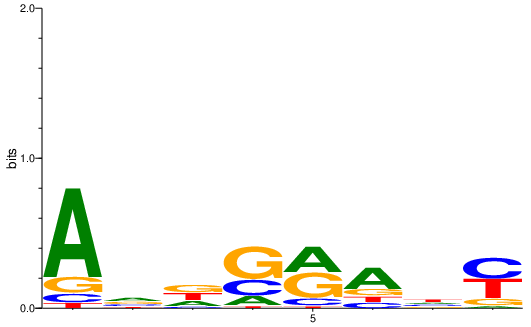

In [12]:
seqlogo.seqlogo(seqlogo.CompletePm(pfm = norm_pfm.T), ic_scale=True)

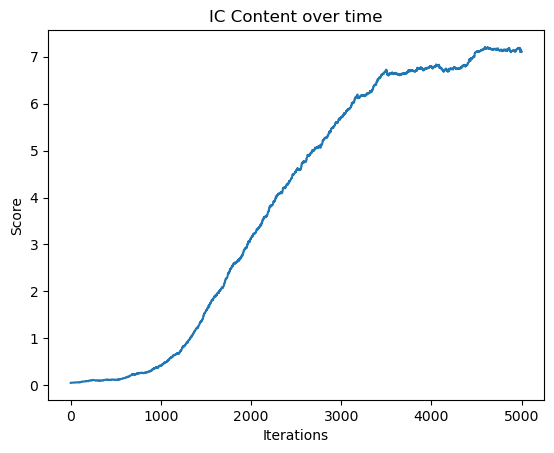

In [13]:
#Visualize IC content over iterations

import matplotlib.pyplot as plt

plt.plot(ic_list)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('IC Content over time')
plt.show()